In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import json
import math
import os
import statistics
import sys

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from eventdt import twitter
from eventdt.twitter import corpus

from multiplex import drawable

file = os.path.expanduser('~/DATA/c6-tdt/data/#SCOCZE/event.json')
track = [ 'schick', 'goal' ]

Set up the visualization style to use in this notebook.

In [2]:
def volume(bin, track=None, filtered=False, *args, **kwargs):
    """
    Count the number of tweets in the given bin.

    :param bin: A bin containing a list of tweets to count.
    :type bin: list of dict
    :param track: The keyword to track.
    :type track: None or str

    :return: The number of tweets in the bin.
    :rtype: int
    """
    
    return len(bin) if track is None else len([ tweet for tweet in bin if track.lower() in twitter.full_text(tweet).lower() ])

In [3]:
with open(file) as f:
    total = corpus.aggregate(f, agg=volume, bin_size=60)

In [4]:
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 9 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 13, 'markeredgewidth': 3, 'markeredgecolor': 'C4' })
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'align': 'right', 'fontsize': 'smaller',
                     'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }

faded_style = dict(style)
faded_style.update({ 'color': 'C5' })
highlight_style = dict(style)
highlight_style.update({ 'color': 'C0' })

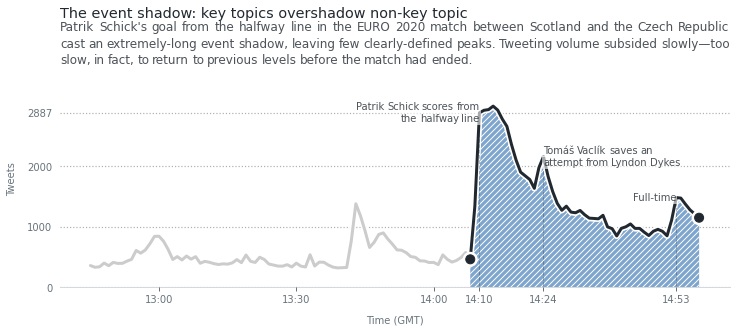

In [5]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(total.keys())[1:-1]
term_volume = [ total.get(timestamp, { }).get(term) for timestamp in timestamps ]
annotations = {
    (timestamps.index(timestamps[-6]), term_volume[timestamps.index(timestamps[-6])]): {
        'text': 'Full-time',
        'style': { 'align': 'right' }
    },
    (timestamps.index(timestamps[99]), term_volume[timestamps.index(timestamps[99])]): {
        'text': 'Tomáš Vaclík saves an attempt from Lyndon Dykes',
        'style': { 'align': 'left' }
    },
    (timestamps.index(timestamps[85]), term_volume[timestamps.index(timestamps[85])]): {
        'text': 'Patrik Schick scores from the halfway line',
        'style': { 'align': 'right' }
    }
}
shadow = (83, -1)

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(12,4))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(term_volume)), term_volume, **faded_style)

shadow_timestamps = timestamps[shadow[0]:shadow[1]] + [ timestamps[shadow[1]] ]
shadow_volume = [ total.get(timestamp, { }).get(term) for timestamp in shadow_timestamps ]
viz.draw_time_series(range(shadow[0], shadow[0] + len(shadow_timestamps)), shadow_volume,
                     markevery=[0, -1], **marker_style, **style)
viz.fill_between(range(shadow[0], shadow[0] + len(shadow_timestamps)), shadow_volume, 0,
                 hatch='////', color='C1', linewidth=0, edgecolor='C4', alpha=1)

"""
Annotate the visualization.
"""
ylim = viz.get_ylim()
for (x, y), annotation in annotations.items():
    text, _style = annotation['text'], annotation['style']
    _astyle = dict(annotation_style)
    _astyle.update(_style)
    _x = (x - 30, x) if _astyle['align'] == 'right' else (x, x + 30)
    viz.vlines(x, ymin=ylim[0], ymax=y, **line_style)
#     viz.annotate(text, _x, y, marker=marker_style, **_astyle)
    viz.annotate(text, _x, y, **_astyle)

"""
Finalize the visualization.
"""
viz.set_title('The event shadow: key topics overshadow non-key topic', loc='left')
viz.set_caption("""Patrik Schick's goal from the halfway line in the EURO 2020 match between Scotland and the Czech Republic cast an extremely-long event shadow, leaving few clearly-defined peaks.
                   Tweeting volume subsided slowly—too slow, in fact, to return to previous levels before the match had ended.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not (timestamp + 60 * 30) % (60 * 30) ]
del xticks[-1]
xticks += [ x for x, y in annotations ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(term_volume) * 1.2))
yticks = list(range(0, math.ceil(max(term_volume)), 1000))
viz.set_yticks(yticks + [sorted(annotations.keys(), key=lambda xy: xy[1], reverse=True)[0][1]])
viz.set_axisbelow(True)
viz.savefig('../exports/6.1-event-shadow.png', dpi=300, bbox_inches='tight')